In [1]:
import io
import locale


import matplotlib
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter
import numpy as np
import pandas as pd
from PIL import Image
import requests


from eleicoes.despesas import dados_despesas
from eleicoes.candidatos import dados_candidatos
#from calcbacen import corrigir_por_indice_preco

In [2]:
plt.style.use('ggplot')
%matplotlib inline

locale.setlocale(locale.LC_ALL, 'pt_BR.utf8')
pd.options.display.float_format = lambda x: locale.format('%.2f', x, grouping=True)
pd.options.display.max_columns = 50

# Selecão das eleições e da cidade que será analisada

In [3]:
ANOS = (2008, 2012, 2016)
SIGLA_UF = 'SP'
MUNICIPIO = 71072  # São Paulo

# Importa as informações dos candidatos participantes das eleições

Seleciona candidatos ao cargo de prefeito com candidatura deferida.

In [4]:
cod_prefeito = 11
cod_deferido = 2

In [5]:
dados_candidatos_eleicao = {}
for ano in ANOS:
    dados_candidatos_eleicao[ano] = dados_candidatos(ano, SIGLA_UF, MUNICIPIO)
candidatos = pd.concat(dados_candidatos_eleicao.values(), ignore_index=True)
candidatos['COD_SITUACAO_CANDIDATURA'] = candidatos['COD_SITUACAO_CANDIDATURA'].astype(int)
candidatos = candidatos.query('COD_CARGO == @cod_prefeito & COD_SITUACAO_CANDIDATURA == @cod_deferido')
candidatos['COD_SIT_TOT_TURNO'] = candidatos['COD_SIT_TOT_TURNO'].astype(int)
candidatos.head()

,ANO_ELEICAO,CODIGO_NACIONALIDADE,COD_CARGO,COD_COR_RACA,COD_ESTADO_CIVIL,COD_GRAU_INSTRUCAO,COD_LEGENDA,COD_MUNICIPIO_NASCIMENTO,COD_OCUPACAO,COD_SEXO,COD_SITUACAO_CANDIDATURA,COD_SIT_TOT_TURNO,COMPOSICAO_LEGENDA,CPF_CANDIDATO,DATA_GERACAO,DATA_NASCIMENTO,DESC_CARGO,DESC_COR_RACA,DESC_ELEICAO,DESC_ESTADO_CIVIL,DESC_GRAU_INSTRUCAO,DESC_NACIONALIDADE,DESC_OCUPACAO,DESC_SEXO,DESC_SITUACAO_CANDIDATURA,DESC_SIT_TOT_TURNO,DESC_UE,DESPESA_MAX_CAMPANHA,HORA_GERACAO,IDADE_DATA_ELEICAO,NM_EMAIL,NOME_CANDIDATO,NOME_LEGENDA,NOME_MUNICIPIO_NASCIMENTO,NOME_PARTIDO,NOME_URNA_CANDIDATO,NUMERO_CANDIDATO,NUM_PARTIDO,NUM_TITULO_ELEITORAL_CANDIDATO,NUM_TURNO,SEQUENCIAL_CANDIDATO,SIGLA_LEGENDA,SIGLA_PARTIDO,SIGLA_UE,SIGLA_UF,SIGLA_UF_NASCIMENTO
0,2008,1,11,nan,3,8,2817,NaN,110,4,2,4,#NE#,11648976832,29/02/2016,11-DEC-66,PREFEITO,NaN,ELEIÇÕES 2008,CASADO(A),SUPERIOR COMPLETO,BRASILEIRA NATA,AGENTE POSTAL,FEMININO,DEFERIDO,NÃO ELEITO,SÃO PAULO,nan,19:14:17,nan,NaN,ANAI CAPRONI PINTO,#NE#,SAO BERNARDO DO CAMPO,PARTIDO DA CAUSA OPERÁRIA,ANAI CAPRONI,29,29,072495050175,1,32021,#NE#,PCO,71072,SP,SP
1,2008,1,11,nan,3,8,683,NaN,125,2,2,4,#NE#,07618069891,29/02/2016,23-FEB-46,PREFEITO,NaN,ELEIÇÕES 2008,CASADO(A),SUPERIOR COMPLETO,BRASILEIRA NATA,ADMINISTRADOR,MASCULINO,DEFERIDO,NÃO ELEITO,SÃO PAULO,nan,19:14:17,nan,NaN,CIRO TIZIANI MOURA,TOSTÃO CONTRA O MILHÃO,CAMPINAS,PARTIDO TRABALHISTA CRISTÃO,CIRO,36,36,086867500141,1,6167,#NE#,PTC,71072,SP,SP
3,2008,1,11,nan,1,8,1020,NaN,142,2,2,4,#NE#,04497643387,29/02/2016,08-APR-50,PREFEITO,NaN,ELEIÇÕES 2008,SOLTEIRO(A),SUPERIOR COMPLETO,BRASILEIRA NATA,PROFESSOR DE ENSINO SUPERIOR,MASCULINO,DEFERIDO,NÃO ELEITO,SÃO PAULO,nan,19:14:17,nan,NaN,EDMILSON SILVA COSTA,#NE#,PEDREIRAS,PARTIDO COMUNISTA BRASILEIRO,EDMILSON COSTA,21,21,000221640132,1,8882,#NE#,PCB,71072,SP,MA
4,2008,1,11,nan,3,8,2645,NaN,111,2,2,4,#NE#,54914906872,29/02/2016,07-NOV-52,PREFEITO,NaN,ELEIÇÕES 2008,CASADO(A),SUPERIOR COMPLETO,BRASILEIRA NATA,MÉDICO,MASCULINO,DEFERIDO,NÃO ELEITO,SÃO PAULO,nan,19:14:17,nan,NaN,GERALDO JOSE RODRIGUES ALCKMIN FILHO,"SÃO PAULO, NA MELHOR DIREÇÃO",PINDAMONHANGABA,PARTIDO DA SOCIAL DEMOCRACIA BRASILEIRA,GERALDO ALCKMIN,45,45,035204110175,1,29830,#NE#,PSDB,71072,SP,SP
5,2008,1,11,nan,1,8,74,NaN,275,2,2,6,#NE#,08884761832,29/02/2016,12-AUG-60,PREFEITO,NaN,ELEIÇÕES 2008,SOLTEIRO(A),SUPERIOR COMPLETO,BRASILEIRA NATA,PREFEITO,MASCULINO,DEFERIDO,2º TURNO,SÃO PAULO,nan,19:14:17,nan,NaN,GILBERTO KASSAB,SÃO PAULO NO RUMO CERTO,SÃO PAULO,DEMOCRATAS,GILBERTO KASSAB,25,25,086302290191,1,608,#NE#,DEM,71072,SP,SP


## Candidatos - 2008

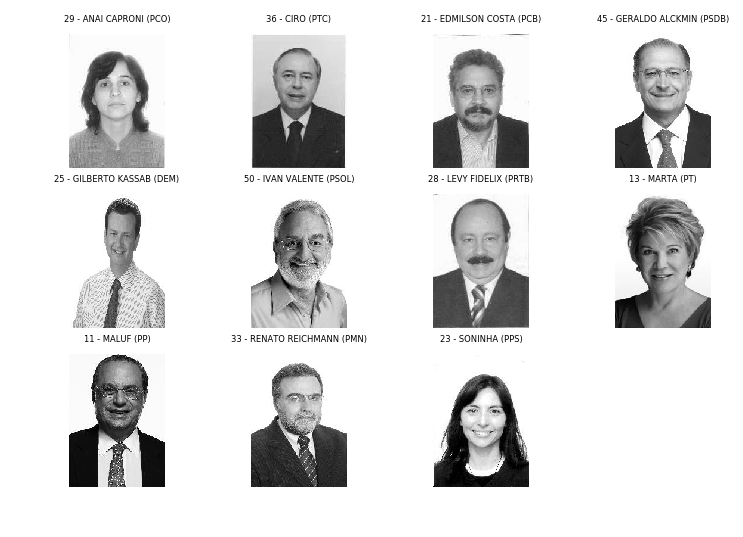

In [6]:
colunas = ['SEQUENCIAL_CANDIDATO', 'NUMERO_CANDIDATO', 'NOME_CANDIDATO', 'NOME_URNA_CANDIDATO', 'SIGLA_PARTIDO']
candidatos2008 = (candidatos.query('ANO_ELEICAO == 2008')[colunas].drop_duplicates()
                  .sort_values(by='NOME_CANDIDATO')
                  .reset_index(drop=True))
fig = plt.figure()
fig.set_dpi(150)
for cand in candidatos2008.itertuples():
    a=fig.add_subplot(3, 4, cand.Index + 1)    
    url = (f'http://divulgacandcontas.tse.jus.br/divulga/rest/v1/candidatura/buscar/'
           f'foto/14422/{cand.SEQUENCIAL_CANDIDATO}/{MUNICIPIO}')
    img = Image.open(io.BytesIO(requests.get(url).content))
    img = img.convert('RGB')
    titulo = f'{cand.NUMERO_CANDIDATO} - {cand.NOME_URNA_CANDIDATO} ({cand.SIGLA_PARTIDO})' 
    plt.title(titulo, fontdict={'fontsize': 4})
    plt.axis('off')
    plt.imshow(np.array(img))    

## Candidatos - 2012

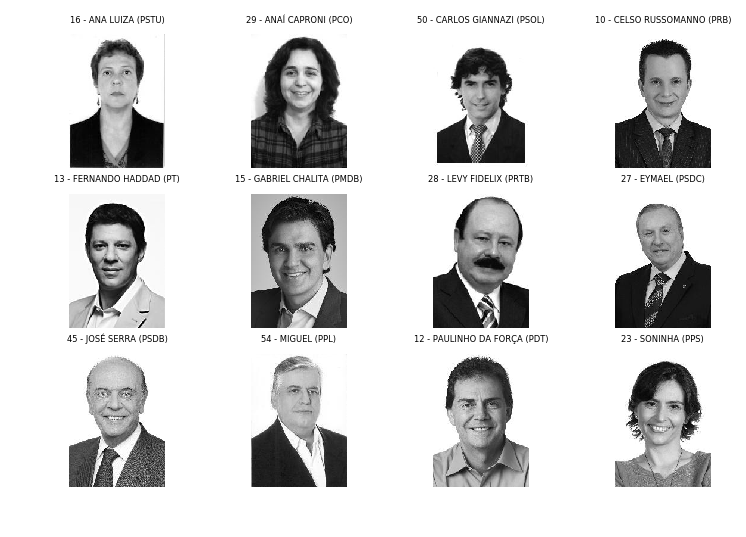

In [7]:
colunas = ['SEQUENCIAL_CANDIDATO', 'NUMERO_CANDIDATO', 'NOME_CANDIDATO', 'NOME_URNA_CANDIDATO', 'SIGLA_PARTIDO']
candidatos2012 = (candidatos.query('ANO_ELEICAO == 2012')[colunas]
                  .drop_duplicates()
                  .sort_values(by='NOME_CANDIDATO')
                  .reset_index(drop=True))

fig = plt.figure()
fig.set_dpi(150)
for cand in candidatos2012.itertuples():
    a=fig.add_subplot(3, 4, cand.Index + 1)    
    url = (f'http://divulgacandcontas.tse.jus.br/divulga/rest/v1/candidatura/buscar/'
           f'foto/1699/{cand.SEQUENCIAL_CANDIDATO}/{MUNICIPIO}')
    img = Image.open(io.BytesIO(requests.get(url).content))
    img = img.convert('RGB')
    titulo = f'{cand.NUMERO_CANDIDATO} - {cand.NOME_URNA_CANDIDATO} ({cand.SIGLA_PARTIDO})' 
    plt.title(titulo, fontdict={'fontsize': 4})
    plt.axis('off')
    plt.imshow(np.array(img))    

## Candidatos - 2016

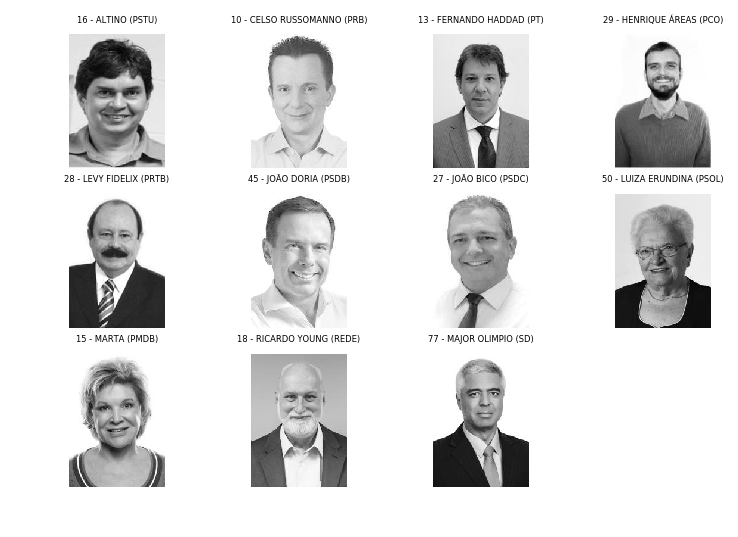

In [8]:
colunas = ['SEQUENCIAL_CANDIDATO', 'NUMERO_CANDIDATO', 'NOME_CANDIDATO', 'NOME_URNA_CANDIDATO', 'SIGLA_PARTIDO']
candidatos2016 = (candidatos.query('ANO_ELEICAO == 2016')[colunas]
                  .drop_duplicates()
                  .sort_values(by='NOME_CANDIDATO')
                  .reset_index(drop=True))

fig = plt.figure()
fig.set_dpi(150)
for cand in candidatos2016.itertuples():
    a=fig.add_subplot(3, 4, cand.Index + 1)
    url = (f'http://divulgacandcontas.tse.jus.br/divulga/rest/v1/candidatura/buscar/'
           f'foto/2/{cand.SEQUENCIAL_CANDIDATO}/{MUNICIPIO}')
    img = Image.open(io.BytesIO(requests.get(url).content))
    img = img.convert('RGB')
    titulo = f'{cand.NUMERO_CANDIDATO} - {cand.NOME_URNA_CANDIDATO} ({cand.SIGLA_PARTIDO})'
    plt.title(titulo, fontdict={'fontsize': 4})
    plt.axis('off')
    plt.imshow(np.array(img))    

# Importa os dados de despesas dos candidatos ao cargo de Prefeito

In [9]:
cargo = 'Prefeito'
despesas_eleicao = {}
columns = ['numero_candidato', 'nome_candidato', 'sigla_partido', 'cpfcnpj_fornecedor',
           'nome_fornecedor_receita_federal', 'setor_economico_fornecedor',
           'tipo_documento', 'data_despesa', 'tipo_despesa', 'valor_despesa']
for ano in ANOS:
    despesas_eleicao[ano] = dados_despesas(ano, SIGLA_UF, MUNICIPIO).query('cargo == @cargo')
    despesas_eleicao[ano].insert(0, 'ano_eleicao', [ano] * len(despesas_eleicao[ano]))    

despesas = pd.concat(despesas_eleicao.values(), ignore_index=True)
despesas['data_despesa'] = pd.to_datetime(despesas['data_despesa'].map(lambda x: x[:10]), dayfirst=True)
despesas.insert(9, 'mmaaaa_despesa', despesas['data_despesa'].map(lambda x: f'{str(x.month).zfill(2)}/{x.year}'))
despesas.head()

,ano_eleicao,cargo,cnpj_prestador_conta,cod_eleicao,cod_municipio,cod_setor_economico_fornecedor,cpf_candidato,cpf_vicesuplente,cpfcnpj_fornecedor,mmaaaa_despesa,data_despesa,data_despesa_1,data_hora,desc_eleicao,descricao_despesa,nom_municipio,nome_candidato,nome_fornecedor,nome_fornecedor_receita_federal,numero_candidato,numero_documento,sequencial_candidato,setor_economico_fornecedor,sigla_partido,tipo_despesa,tipo_documento,uf,valor_despesa
0,2008,Prefeito,nan,nan,71072,nan,NaN,nan,"9.684.534.000.159,00",10/2008,2008-10-22,22/10/2008,NaN,NaN,NaN,SÃO PAULO,PAULO SALIM MALUF,ComitÃª Financeiro Municipal Ãnico - PP - SP ...,NaN,11,NaN,9908,NaN,PP,DoaÃ§Ãµes financeiras a outros candidatos e/ou...,NaN,SP,"380,00"
1,2008,Prefeito,nan,nan,71072,nan,NaN,nan,"9.684.534.000.159,00",10/2008,2008-10-05,05/10/2008,NaN,NaN,NaN,SÃO PAULO,PAULO SALIM MALUF,BAIXA DE RECURSOS ESTIMÃVEIS EM DINHEIRO PROV...,NaN,11,NaN,9908,NaN,PP,Baixa de Recursos EstimÃ¡veis em Dinheiro,NaN,SP,"6.243,12"
2,2008,Prefeito,nan,nan,71072,nan,NaN,nan,"7.605.731.825,00",10/2008,2008-10-10,10/10/2008,NaN,NaN,NaN,SÃO PAULO,PAULO SALIM MALUF,WILLIAN JEFERSON LOPES RODRIGUES,NaN,11,1,9908,NaN,PP,Despesas com pessoal,NaN,SP,"500,00"
3,2008,Prefeito,nan,nan,71072,nan,NaN,nan,"10.099.195.801,00",10/2008,2008-10-10,10/10/2008,NaN,NaN,NaN,SÃO PAULO,PAULO SALIM MALUF,CARLOS EDUARDO CORREA,NaN,11,1,9908,NaN,PP,Despesas com pessoal,NaN,SP,"670,00"
4,2008,Prefeito,nan,nan,71072,nan,NaN,nan,"10.567.149.803,00",10/2008,2008-10-10,10/10/2008,NaN,NaN,NaN,SÃO PAULO,PAULO SALIM MALUF,JAILSON JOSE DA SILVA,NaN,11,1,9908,NaN,PP,Despesas com pessoal,NaN,SP,"340,00"


## Validação dos Dados

### 2008

In [10]:
qtd_candidatos_2008 = len(candidatos2008)

In [11]:
consolidado2008 = despesas.query('ano_eleicao == 2008').groupby(['nome_candidato', 'numero_candidato']).agg({'valor_despesa': 'sum'}).sort_values(by='valor_despesa')
assert len(consolidado2008 == qtd_candidatos_2008)
consolidado2008

,,valor_despesa
nome_candidato,numero_candidato,
ANAI CAPRONI PINTO,29,"3.550,00"
EDMILSON SILVA COSTA,21,"13.053,11"
RUY RENATO REICHMANN,33,"43.770,23"
CIRO TIZIANI MOURA,36,"78.740,00"
JOSÃ LEVY FIDELIX DA CRUZ,28,"112.954,70"
IVAN VALENTE,50,"173.785,92"
SONIA FRANCINE GASPAR MARMO,23,"550.136,04"
PAULO SALIM MALUF,11,"1.312.125,38"
GERALDO JOSE RODRIGUES ALCKMIN FILHO,45,"16.379.049,08"


### 2012

In [12]:
qtd_candidatos_2012 = len(candidatos2012)

In [13]:
consolidado2012 = despesas.query('ano_eleicao == 2012').groupby(['nome_candidato', 'numero_candidato']).agg({'valor_despesa': 'sum'}).sort_values(by='valor_despesa')
assert len(consolidado2012 == qtd_candidatos_2012)
consolidado2012

,,valor_despesa
nome_candidato,numero_candidato,
ANAI CAPRONI PINTO,29,"4.000,00"
ANA LUIZA DE FIGUEIREDO GOMES,16,"25.104,47"
CARLOS ALBERTO GIANNASI,50,"118.525,19"
JOSÉ MARIA EYMAEL,27,"141.594,13"
MIGUEL MANSO PEREZ,54,"335.279,10"
JOSÉ LEVY FIDELIX DA CRUZ,28,"339.403,50"
SONIA FRANCINE GASPAR MARMO,23,"423.954,02"
PAULO PEREIRA DA SILVA,12,"2.002.595,35"
CELSO UBIRAJARA RUSSOMANNO,10,"4.376.665,51"


### 2016

In [14]:
qtd_candidatos_2016 = len(candidatos2016)

In [15]:
consolidado2016 = despesas.query('ano_eleicao == 2016').groupby(['nome_candidato', 'numero_candidato']).agg({'valor_despesa': 'sum'}).sort_values(by='valor_despesa')
assert len(consolidado2016 == qtd_candidatos_2016)
consolidado2016

,,valor_despesa
nome_candidato,numero_candidato,
HENRIQUE ÁREAS DE ARAUJO,29,"1.351,41"
ALTINO DE MELO PRAZERES JÚNIOR,16,"36.592,39"
SERGIO OLIMPIO GOMES,77,"95.544,19"
JOÃO BICO DE SOUZA,27,"320.010,65"
JOSE LEVY FIDELIX DA CRUZ,28,"339.919,58"
LUIZA ERUNDINA DE SOUSA,50,"353.543,18"
RICARDO YOUNG SILVA,18,"630.589,30"
CELSO UBIRAJARA RUSSOMANNO,10,"7.022.227,24"
MARTA TERESA SUPLICY,15,"7.068.189,45"


# Corrige os valores pelo IPCA até dez/17

In [16]:
from calcbacen.calconline import CalcOnline

In [17]:
valores = despesas[['valor_despesa', 'mmaaaa_despesa']].drop_duplicates()
valores['dt_final'] = '12/2017'
valores['indice'] = 'IPC-A'
valores.head(10)

,valor_despesa,mmaaaa_despesa,dt_final,indice
0,"380,00",10/2008,12/2017,IPC-A
1,"6.243,12",10/2008,12/2017,IPC-A
2,"500,00",10/2008,12/2017,IPC-A
3,"670,00",10/2008,12/2017,IPC-A
4,"340,00",10/2008,12/2017,IPC-A
5,"1.000,00",10/2008,12/2017,IPC-A
15,"12.000,00",07/2008,12/2017,IPC-A
16,"14.750,00",08/2008,12/2017,IPC-A
17,"550,00",09/2008,12/2017,IPC-A
18,"1.000,00",09/2008,12/2017,IPC-A


In [25]:
import time
t1 = time.time()
calc = CalcOnline(50)
cols = ['valor_despesa', 'mmaaaa_despesa', 'dt_final', 'valor_atualizado']
valores_atualizados = pd.DataFrame(calc.post_async(valores.itertuples(index=False)), columns=cols)
valores_atualizados
print(f'Finalizado em: {time.time() - t1}')

ConnectionError: HTTPSConnectionPool(host='www3.bcb.gov.br', port=443): Max retries exceeded with url: /CALCIDADAO/publico/corrigirPorIndice.do?method=corrigirPorIndice (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x7fdd89c2eef0>: Failed to establish a new connection: [Errno 110] Tempo esgotado para conexão',))

In [24]:
valores_atualizados.to_csv('valores_atualizados.csv', index=False, sep=';')

In [ ]:
valores = despesas_1216[['mmaaaa_despesa', 'valor_despesa']].drop_duplicates().reset_index(drop=True)
for i in valores.itertuples():    
    val = corrigir_por_indice_preco(i.valor_despesa, i.mmaaaa_despesa, '12/2017', 'IPC-A')
    valores.loc[i.Index, 'valor_atlz_dez17'] = val
    print(i.Index, i.valor_despesa, val)

In [ ]:
for i in despesas_1216.itertuples():    
    val = co'rrigir_por_indice_preco(i.valor_despesa, i.mmaaaa_despesa, '12/2017', 'IPC-A')
    print(i.Index, val)

In [ ]:
for i in tnrange(10, desc='1st loop'):
    for j in tqdm_notebook(xrange(100), desc='2nd loop'):
        sleep(0.01)
#despesas_1216['valor_despesa_dez17'] = despesas_1216.head(10).apply(lambda x: corrigir_por_indice_preco( x.valor_despesa, x.mmaaaa_despesa, '12/2017','IPC-A'), axis=1)

## Seleciona os candidatos eleitos e marca no dataset de despesas

In [ ]:
prefeito = 11
eleito = 1
colunas = ['ANO_ELEICAO', 'NUM_TURNO', 'COD_LEGENDA', 'SIGLA_PARTIDO', 'NUMERO_CANDIDATO',
           'NOME_CANDIDATO', 'DESC_CARGO', 'DESC_SIT_TOT_TURNO']

eleitos = candidatos.query('COD_SIT_TOT_TURNO == @eleito')[colunas]
eleitos.columns = [col.lower() for col in eleitos.columns]
eleitos.head()

In [ ]:
colunas = ['numero_candidato', 'nome_candidato', 'desc_sit_tot_turno']
despesas = despesas.merge(eleitos[colunas], how='left', on=['numero_candidato', 'nome_candidato'])

In [ ]:
despesas.head()

# Total de Despesas por Eleição

In [ ]:
por_eleicao = despesas_1216.groupby('ano_eleicao')

In [ ]:
def sum_millions(x):
    return sum(x) / 1_000_000

In [ ]:
title = 'Gráfico 1 - Despesa Total por Eleição (R$ milhões)'
ax = por_eleicao.agg({'valor_despesa': sum_millions}).plot(kind='bar', title=title)
for p in ax.patches:             
    label = locale.format('%.2f', p.get_height(), True)
    x = p.get_x() + p.get_width() / 2
    y = 2
    ax.text(x, y, label, ha='center', va='bottom', fontdict={'fontsize':12, 'color': 'white'})            
plt.tight_layout()
plt.show()

# Despesa por candidato

In [ ]:
por_candidato = despesas_1216.groupby(['ano_eleicao', 'numero_candidato']).agg({'valor_despesa': sum_millions})

fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
fig.set_size_inches(10, 4)

for n, ano_eleicao in enumerate(ANOS):
    df = por_candidato.xs(ano_eleicao).sort_values(by='valor_despesa')
    ax = axes[n]        
    ax = df.plot(kind='bar', ax=ax, color='b')
    ax.set_title(f'Despesas por Candidato - {ano_eleicao} (R$ milhões)')
    media = [df['valor_despesa'].mean()] * len(df)
    mean_line = ax.plot(np.arange(len(df)), media, label='Mean', linestyle='--')
    ax.text(0, df['valor_despesa'].mean() + 1, locale.format('%.2f', df['valor_despesa'].mean()))
    
    
plt.tight_layout()
plt.show()

# Despesas - Por Tipo de Despesa

In [ ]:
def normaliza_classes(x):
    if x.startswith('Baixa de'):
        return x.split(' - ')[1]
    return x

In [ ]:
cols = ['ano_eleicao', 'tipo_despesa', 'valor_despesa']
tp_despesa = despesas_1216[cols].reset_index(drop=True)
tp_despesa.loc[:, 'tipo_despesa'] = tp_despesa.loc[:, 'tipo_despesa'].map(normaliza_classes)
tp_despesa['perc_despesa'] = tp_despesa['valor_despesa']
def perc(x):
    print(x)
    return sum(x)
despesa_val = tp_despesa.groupby(['ano_eleicao', 'tipo_despesa']).agg({'valor_despesa': 'sum'})
despesa_pct = despesa_val.groupby(level=0).apply(lambda x:
                                                 100 * x / float(x.sum()))


despesa_pct.loc[slice(2012, 2012), 'valor_despesa'].sum(), despesa_pct.loc[slice(2016, 2016), 'valor_despesa'].sum()

In [ ]:
variacao_pleito = despesa_pct.pivot_table(index='tipo_despesa', values='valor_despesa',
                                          columns=['ano_eleicao']).reset_index().fillna(0)
variacao_pleito['variacao_2012_2016'] =  variacao_pleito[2016] - variacao_pleito[2012]
variacao_pleito = variacao_pleito.sort_values(by='variacao_2012_2016', ascending=False).reset_index(drop=True)
variacao_pleito.columns.name = None
variacao_pleito.head()

In [ ]:
ax.patches

In [ ]:
from itertools import cycle

soma_2012 = 0
soma_2016 = 0

color_cycle = cycle(['g', 'r', 'b', 'c', 'm', 'y', 'k'])
labels = []
handles = []
for i, color in zip(variacao_pleito.sort_values(by=2012, ascending=False).head(10).itertuples(), color_cycle):            
    ax = plt.bar('2012', i._2, bottom=soma_2012, color=color)
    ax1 = plt.bar('2016', i._3, bottom=soma_2016, color=color)
    soma_2012 += i._2
    soma_2016 += i._3
    labels.append(i.tipo_despesa)
    handles.extend(ax.patches)
        
print(soma_2012, soma_2016)
ax = plt.bar('2012', 100 - soma_2012, bottom=soma_2012, color=color)
ax = plt.bar('2016', 100 - soma_2016, bottom=soma_2016, color=color)
labels.append('Outros')
handles.append(handles[0])

plt.legend(handles, labels, bbox_to_anchor=(1.05, 1))   
plt.show()

In [ ]:
tp_despesa.reset_index().sort_values(by=['ano_eleicao', 'perc_total'], ascending=False).query('ano_eleicao == 2012')['perc_total'].sum()

In [ ]:
por_tipo_despesa = despesas_1216[['ano_eleicao', 'tipo_despesa', 'valor_despesa']]
por_tipo_despesa['tipo_despesa'] = por_tipo_despesa['tipo_despesa'].map(lambda x: x.split(' - ')[1] if x.startswith('Baixa de') else x) 
df = por_tipo_despesa.groupby(['ano_eleicao', 'tipo_despesa']).agg({'valor_despesa': 'sum'})
for i in ANOS:
    despesa_total_ano = df.loc[slice(i), 'valor_despesa'].sum()
    df.loc[slice(i), 'perc_despesa'] = df.loc[slice(i), 'valor_despesa'] / despesa_total_ano
df.reset_index().sort_values(by=['ano_eleicao', 'perc_despesa'], ascending=False)

In [ ]:
por_tipo_despesa['tipo_despesa'] = por_tipo_despesa['tipo_despesa'].map(lambda x: x.split(' - ')[1] if x.startswith('Baixa de') else x) 
por_tipo_despesa = por_tipo_despesa.groupby(['ano_eleicao', 'tipo_despesa']).agg({'valor_despesa': sum_millions})
fig, ax = plt.subplots()
df = por_tipo_despesa.xs(2012).reset_index()
df.set_index('tipo_despesa', inplace=True)
ax = df['valor_despesa'].sort_values().plot(kind='bar')
handles, labels = ax.get_legend_handles_labels()
labels = [str(n) + '-' + i.get_text() for n, i in enumerate(ax.xaxis.get_majorticklabels(), 1)]
ax.legend([i for i in handles[0]], labels, bbox_to_anchor=(1.05, 1))
plt.show()

In [ ]:
cols = dados_despesas(ano, SIGLA_UF, MUNICIPIO).columns
cols